# Inference

The purpose of this notebook is to allow for evaluation/sampling with a trained NF model

## Setup

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from util import PVect, theta_func, r_func
from IPython.display import clear_output


Using device cuda:0


In [2]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)

### Load data from .pt file (created by preprocess.py)

## Neural Spline Flow

In [4]:
slurm = True

In [5]:
# Define flows
run_num = 4
run_num_str = str(run_num)

K = 1

latent_size = 1
hidden_units = 100
hidden_layers = 6
context_size = 3
num_context = 3
K_str = str(K)
batch_size= 2000
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)


In [6]:
import datetime
x = datetime.datetime.now()
today = x.strftime("%B_%d")
model_date = "July_22"
# model_path = "models/context_3/" + today + "/"
# checkdir(model_path)
model_path = "models/" + model_date + "/"
checkdir(model_path)

samples_path = "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)

In [7]:
model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")

If evaluating test data, just load here:

In [26]:
test_data = torch.load(test_data_path + "full_test_data_run_" + run_num_str+"_" +K_str+"flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pt")

If evaluating on new root file, process first:

### Evaluation

In [27]:
min_time = min(test_data[:, num_context + 1])
skipped = np.array([])
eval_batch_size = 1000000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size]
eval_test_data = eval_test_data.to("cpu")
model = model.to("cpu")
samples = torch.empty(eval_test_data.shape[0])

for i in tqdm(range(eval_max_iter)):
    begin = eval_batch_size * i
    end = eval_batch_size * (i + 1)
    it_data = eval_test_data[begin:end]
    context = torch.empty(it_data.size()[0],3)
    context[:,0] = it_data[:,0]
    context[:,1] = it_data[:,1]
    context[:,2] = it_data[:,2]
#     context[:,0] = 1
#     context[:,1] = 1
#     context[:,2] = 1
    timings = it_data[:,3]
    
    # Initialize a mask for valid samples
    valid_samples = torch.zeros(eval_batch_size, dtype=torch.bool)
    batch_samples = torch.empty(eval_batch_size)
    
    while not valid_samples.all():
        # Generate samples for the invalid positions
        new_samples = model.sample(num_samples=(~valid_samples).sum(), context=context[~valid_samples])[0].cpu().detach().squeeze(1)
        
        # Update the samples and the valid_samples mask
        batch_samples[~valid_samples] = new_samples
        valid_samples = batch_samples >= min_time
    
    samples[begin:end] = batch_samples + timings
# Count and report the number of resampled points

100%|██████████| 11/11 [05:26<00:00, 29.66s/it]


In [28]:
torch.save(samples,samples_path + "run_" + run_num_str+ "_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pt")
torch.save(eval_test_data,test_data_path + "run_" + run_num_str+ "_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pt")

# samples = torch.load("data/samples/July_11/run_5_6_flows_4hl_100hu_5000_bs.pt")
# eval_test_data = torch.load("data/test/July_11/run_5_6_flows_4hl_100hu_5000_bs.pt")

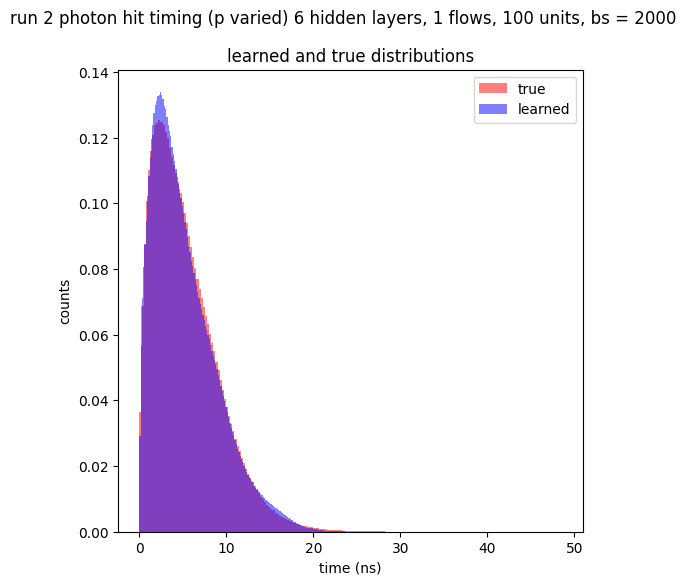

In [29]:
sample_fig, sample_axs = plot.subplots(1,1,figsize=(6,6))
sample_fig.suptitle("run 2 photon hit timing (p varied) 6 hidden layers, 1 flows, 100 units, bs = 2000")
sample_axs.hist(eval_test_data[:,4],bins = 200, color = 'red', alpha = 0.5, label = 'true', density = True)
sample_axs.hist(samples,bins = 200, alpha = 0.5,color = 'blue', label = 'learned', density = True)
sample_axs.set_title("learned and true distributions")
sample_axs.set_xlabel("time (ns)")
sample_axs.set_ylabel("counts")
sample_axs.legend(loc='upper right')
sample_fig.show()

In [10]:
sample_fig.savefig(test_dist_path + "run_" + run_num_str+ "_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pdf")

Multidimensional binning

In [30]:
data_tensor = eval_test_data
num_bins = 8

sample_means = np.empty((num_bins,num_bins))
data_means = np.empty((num_bins,num_bins))

# Extract the relevant features
feature1 = data_tensor[:, 0].numpy()
feature2 = data_tensor[:, 2].numpy()
target_feature = data_tensor[:, 4].numpy()

samples_np = samples.numpy()

# Calculate bin edges for feature1 and feature2
f1_bins = np.linspace(feature1.min(), feature1.max(), num_bins + 1)
f2_bins = np.linspace(feature2.min(), feature2.max(), num_bins + 1)

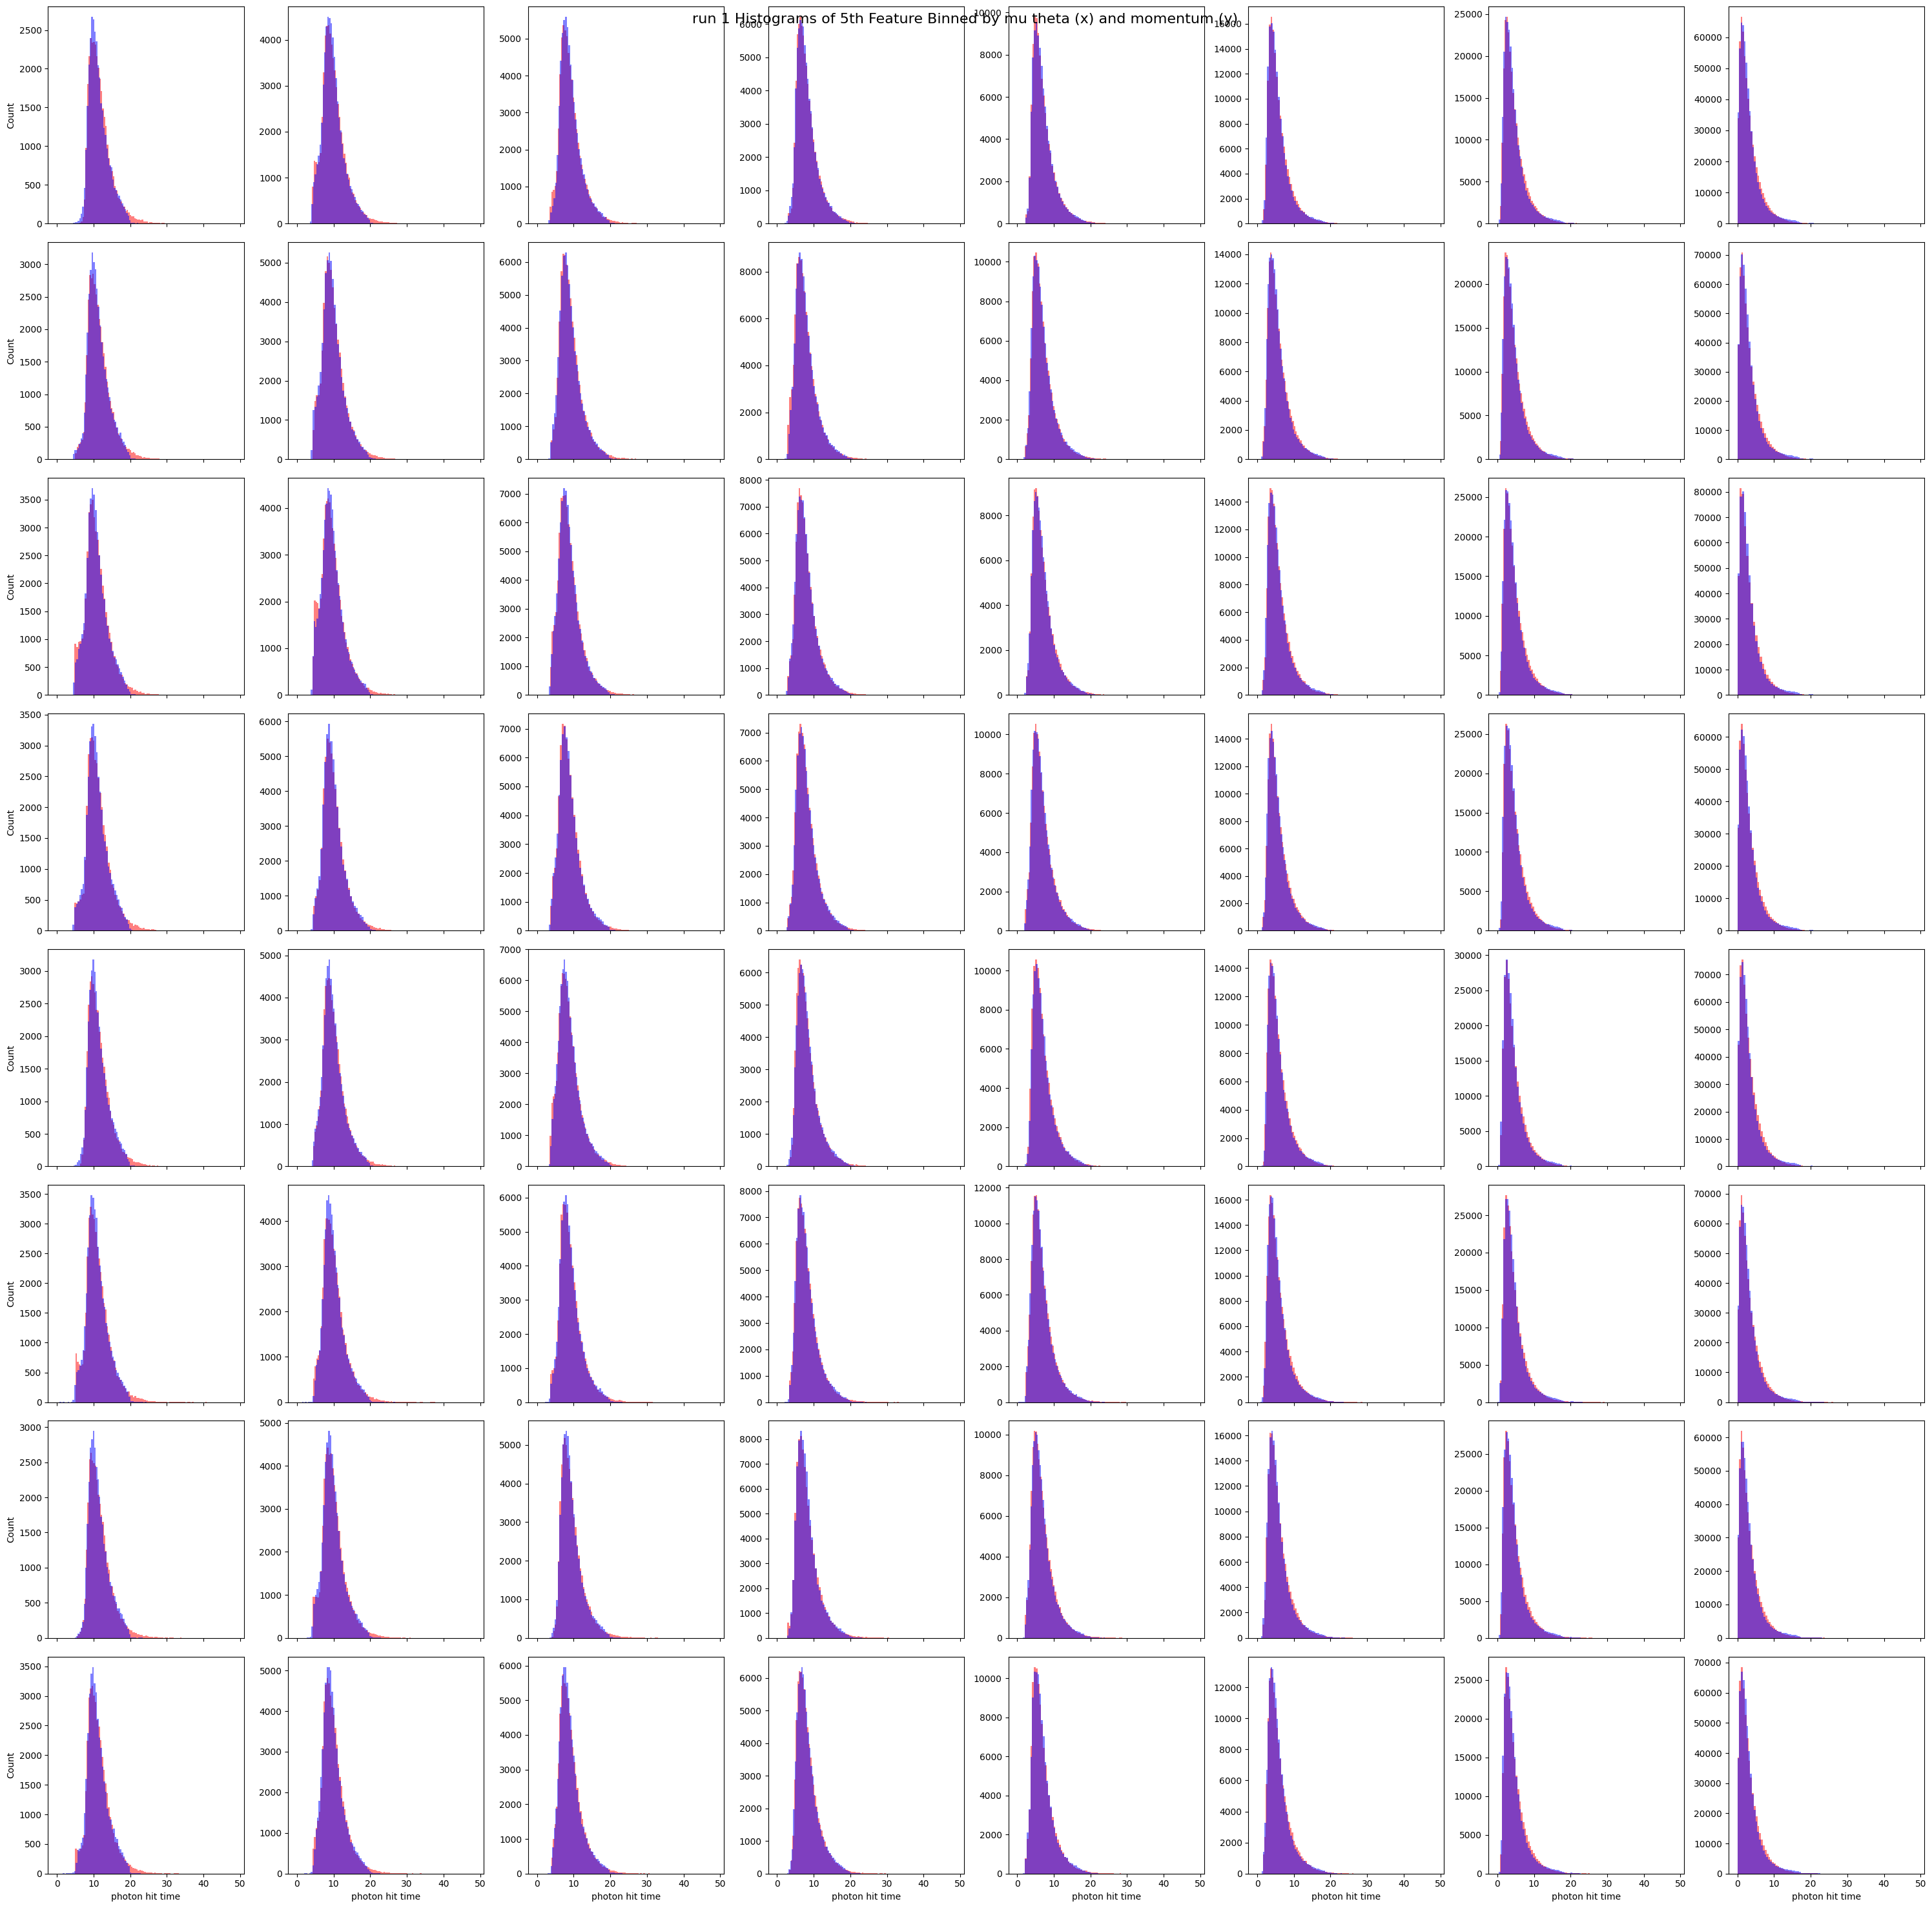

In [31]:
# Create the figure and subplots
fig, axs = plot.subplots(num_bins, num_bins, figsize=(30, 30), sharex=True)
fig.suptitle(r"run 1 Histograms of 5th Feature Binned by mu theta (x) and momentum (y)", fontsize=16)

# Iterate through the grid
for i in range(num_bins):
    for j in range(num_bins):
        # Select data points in the current bin
        mask = (
            (feature1 >= f1_bins[j]) & (feature1 < f1_bins[j+1]) &
            (feature2 >= f2_bins[i]) & (feature2 < f2_bins[i+1])
        )
        bin_data = target_feature[mask]
        bin_samples_np = samples_np[mask]
        
        sample_means[i,j] = np.mean(bin_samples_np)
        data_means[i,j] = np.mean(bin_data)
        data_max = max(bin_data)
        data_min = min(bin_data)
        
        samples_max = max(bin_samples_np)
        samples_min = min(bin_samples_np)
        
        if(samples_max - samples_min > data_max - data_min):
            n_bins_samples = 80
            bin_width = (samples_max - samples_min) / n_bins_samples
            n_bins_data = int(round((data_max - data_min) / bin_width))
        else:
            n_bins_data = 80
            bin_width = (data_max - data_min) / n_bins_data
            n_bins_samples = int(round((samples_max - samples_min) / bin_width))
        # Plot histogram in the current subplot
        axs[i, j].hist(bin_data, bins=n_bins_data, color = 'red',alpha = 0.5)
        axs[i, j].hist(bin_samples_np, bins=n_bins_samples, color = 'blue',alpha = 0.5)
#         axs[i, j].set_title(fr'Hit z pos: [{f1_bins[j]:.2f}, {f1_bins[j+1]:.2f})\n $\theta$: [{f2_bins[i]:.2f}, {f2_bins[i+1]:.2f})')

# Set labels for the outer subplots
for ax in axs[-1, :]:
    ax.set_xlabel('photon hit time')
for ax in axs[:, 0]:
    ax.set_ylabel('Count')

# Add overall x and y labels
# fig.text(0.5, 0.04, '1st Feature Bins', ha='center', va='center', fontsize=14)
# fig.text(0.06, 0.5, '2nd Feature Bins', ha='center', va='center', rotation='vertical', fontsize=14)

plot.tight_layout()
plot.show()
fig.savefig("plots/test_distributions/Binned/July_22/run_4_" + str(num_bins) + "x " + str(num_bins) + "_binned_no_normalized_z_hit_theta.pdf")
# Example usage:
# Assuming you have a PyTorch tensor named 'data_tensor' with shape [x, 5]
# create_histogram_grid(data_tensor)

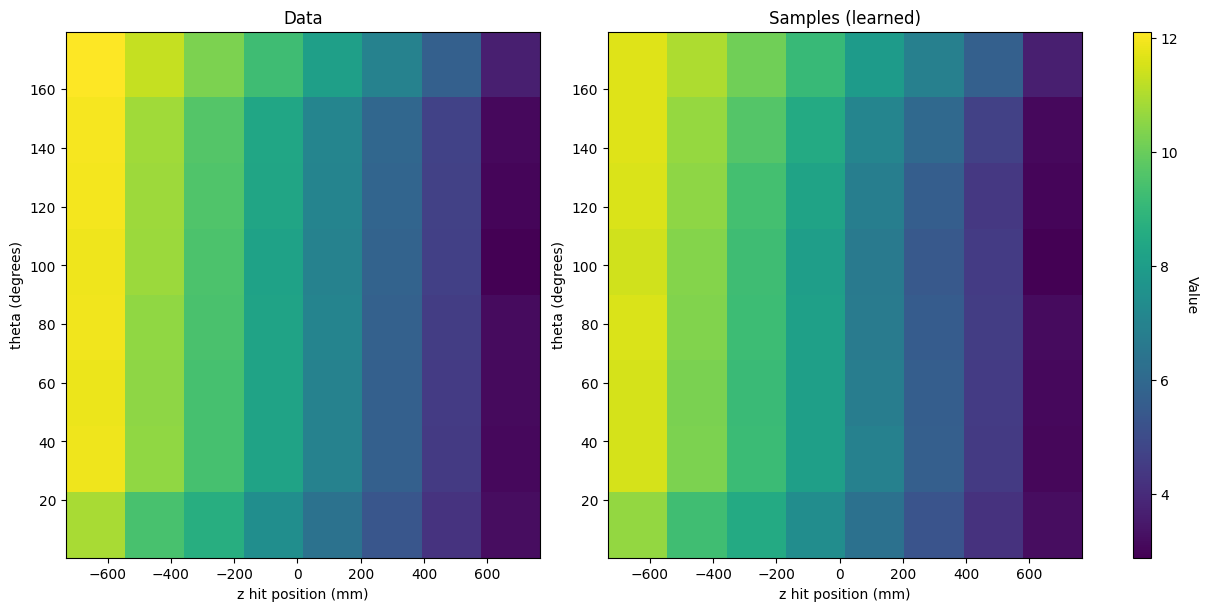

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have these variables defined for both plots:
# f1_bins, f2_bins: lists or arrays of bin edges for both plots
# data_means1, data_means2: 2D arrays of values for the two plots

# Create meshgrids from the bin edges
X, Y = np.meshgrid(f1_bins[:-1] + np.diff(f1_bins)/2, 
                   f2_bins[:-1] + np.diff(f2_bins)/2)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Create the first heatmap
im1 = ax1.pcolormesh(X, Y, data_means, shading='auto', cmap='viridis')
ax1.set_xlabel('z hit position (mm)')
ax1.set_ylabel('theta (degrees)')
# ax1.set_ylabel('momentum (GeV/c)')
# ax1.set_xlabel('theta (degrees)')
ax1.set_title('Data')

# Create the second heatmap
im2 = ax2.pcolormesh(X, Y, sample_means, shading='auto', cmap='viridis')
ax2.set_xlabel('z hit position (mm)')
ax2.set_ylabel('theta (degrees)')
# ax2.set_ylabel('momentum (GeV/c)')
# ax2.set_xlabel('theta (degrees)')
ax2.set_title('Samples (learned)')

# Find the minimum and maximum of both datasets
vmin = min(data_means.min(), sample_means.min())
vmax = max(data_means.max(), sample_means.max())

# Set the color scale of both plots to the same range
im1.set_clim(vmin, vmax)
im2.set_clim(vmin, vmax)

# Add a colorbar that refers to both plots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', aspect=30)
cbar.set_label('Value', rotation=270, labelpad=15)

# Adjust the layout and display the plot
plt.show()
fig.savefig("plots/test_distributions/Binned/July_22/run_4_" + str(num_bins) + "x " + str(num_bins) + "_binned_means_z_theta.pdf")